<a href="https://colab.research.google.com/github/ranimsaidi/image-processing-ML/blob/main/Copie_de_apr%C3%A9s_r%C3%A9haussement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def lbp_extractor(pic):
  from skimage import feature 
  import numpy as np
  import cv2
  
  

  def lbp_features(img):
    
    # LBP operates in images of only one channel, here we go converter
    
    # RGB for cinza scaling using the Luminance method
     #= img[:,:,0].astype(float)*0.3 + img[:,:,1].astype(float)*0.59 + img[:,:,2].astype(float)*0.11
    img_gray= cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY)
    
    
    # here we define the number of points and the radius, padrao = 8, 1
    lbp = feature.local_binary_pattern(img_gray.astype(np.uint8), 3, 3, method="uniform")
    
    # lbp returns a matrix with the codes, so we must extract the histogram
    (hist, _) = np.histogram(lbp, bins=2**12)

    # normalize or histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns

    return hist
  img1 = "ref_verylow.png"
  img2 = "ref_low.png"
  img3 = "ref_medium.png"
  img4 = "ref_high.png"  
  lbp1 = lbp_features(img1)
  lbp2 = lbp_features(img2)
  lbp3 = lbp_features(img3)
  lbp4 = lbp_features(img4) 
  
  lbp = lbp_features(pic)
  score1=cv2.compareHist(lbp.astype(np.float32),lbp1.astype(np.float32), cv2.HISTCMP_CORREL)  
  score2=cv2.compareHist(lbp.astype(np.float32),lbp2.astype(np.float32),  cv2.HISTCMP_CORREL)       
  score3=cv2.compareHist(lbp.astype(np.float32),lbp3.astype(np.float32),  cv2.HISTCMP_CORREL)  
  score4=cv2.compareHist(lbp.astype(np.float32),lbp4.astype(np.float32),  cv2.HISTCMP_CORREL) 
  return score1,score2,score3,score4

In [ ]:
def hog_extractor(img):

 import cv2
 import numpy as np
 def hog_features(pic):
    import matplotlib.pyplot as plt
    from skimage import io
    from skimage import color
    from skimage.transform import resize
    import math
    from skimage.feature import hog
    import numpy as np
    
    img = resize(color.rgb2gray(io.imread(pic)), (128, 64))
    
    
    img = np.array(img)
    
    
    mag = []
    theta = []
    for i in range(128):
      magnitudeArray = []
      angleArray = []
      for j in range(64):
        # Condition for axis 0
        if j-1 <= 0 or j+1 >= 64:
          if j-1 <= 0:
            # Condition if first element
            Gx = img[i][j+1] - 0
          elif j + 1 >= len(img[0]):
            Gx = 0 - img[i][j-1]
        # Condition for first element
        else:
          Gx = img[i][j+1] - img[i][j-1]
        
        # Condition for axis 1
        if i-1 <= 0 or i+1 >= 128:
          if i-1 <= 0:
            Gy = 0 - img[i+1][j]
          elif i +1 >= 128:
            Gy = img[i-1][j] - 0
        else:
          Gy = img[i-1][j] - img[i+1][j]
    
        # Calculating magnitude
        magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
        magnitudeArray.append(round(magnitude, 9))
    
        # Calculating angle
        if Gx == 0:
          angle = math.degrees(0.0)
        else:
          angle = math.degrees(abs(math.atan(Gy / Gx)))
        angleArray.append(round(angle, 9))
      mag.append(magnitudeArray)
      theta.append(angleArray)
    
    mag = np.array(mag)
    
    
    theta = np.array(theta)
    
    number_of_bins = 9
    step_size = 180 / number_of_bins
    
    def calculate_j(angle):
      temp = (angle / step_size) - 0.5
      j = math.floor(temp)
      return j
    
    def calculate_Cj(j):
      Cj = step_size * (j + 0.5)
      return round(Cj, 9)
    
    def calculate_value_j(magnitude, angle, j):
      Cj = calculate_Cj(j+1)
      Vj = magnitude * ((Cj - angle) / step_size)
      return round(Vj, 9)
    
    histogram_points_nine = []
    for i in range(0, 128, 8):
      temp = []
      for j in range(0, 64, 8):
        magnitude_values = [[mag[i][x] for x in range(j, j+8)] for i in range(i,i+8)]
        angle_values = [[theta[i][x] for x in range(j, j+8)] for i in range(i, i+8)]
        for k in range(len(magnitude_values)):
          for l in range(len(magnitude_values[0])):
            bins = [0.0 for _ in range(number_of_bins)]
            value_j = calculate_j(angle_values[k][l])
            Vj = calculate_value_j(magnitude_values[k][l], angle_values[k][l], value_j)
            Vj_1 = magnitude_values[k][l] - Vj
            bins[value_j]+=Vj
            bins[value_j+1]+=Vj_1
            bins = [round(x, 9) for x in bins]
        temp.append(bins)
      histogram_points_nine.append(temp)
    
    epsilon = 1e-05
    
    feature_vectors = []
    for i in range(0, len(histogram_points_nine) - 1, 1):
      temp = []
      for j in range(0, len(histogram_points_nine[0]) - 1, 1):
        values = [[histogram_points_nine[i][x] for x in range(j, j+2)] for i in range(i, i+2)]
        final_vector = []
        for k in values:
          for l in k:
            for m in l:
              final_vector.append(m)
        k = round(math.sqrt(sum([pow(x, 2) for x in final_vector])), 9)
        final_vector = [round(x/(k + epsilon), 9) for x in final_vector]
        temp.append(final_vector)
      feature_vectors.append(temp)
    
    
    hogg_features = np.array(feature_vectors)
    
    hog_reshaped=hogg_features.reshape(3780,)
    return hog_reshaped
 img1 = "ref_verylow.png"
 img2 = "ref_low.png"
 img3 = "ref_medium.png"
 img4 = "ref_high.png"  
 hog1 = hog_features(img1)
 hog2 = hog_features(img2)
 hog3 = hog_features(img3)
 hog4 =hog_features(img4) 
 hogg = hog_features(img)
 score1=cv2.compareHist(hogg.astype(np.float32),hog1.astype(np.float32), cv2.HISTCMP_CORREL)  
 score2=cv2.compareHist(hogg.astype(np.float32),hog2.astype(np.float32),  cv2.HISTCMP_CORREL)       
 score3=cv2.compareHist(hogg.astype(np.float32),hog3.astype(np.float32),  cv2.HISTCMP_CORREL)  
 score4=cv2.compareHist(hogg.astype(np.float32),hog4.astype(np.float32),  cv2.HISTCMP_CORREL) 
 return score1,score2,score3,score4

In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 13.3 MB/s 


In [ ]:
def haralick_extractor(pic):  
  # importing required libraries
  import numpy as np
  import mahotas
  from pylab import imshow, show

  # loading image
  img = mahotas.imread(pic)
    
  # filtering the image
  img = img[:, :, 0]
    
  # setting gaussian filter
  gaussian = mahotas.gaussian_filter(img, 15)

  # setting threshold value
  gaussian = (gaussian > gaussian.mean())

  # making is labelled image
  labeled, n = mahotas.label(gaussian)


  

  # getting haralick features
  h_feature = mahotas.features.haralick(labeled)
  liste= [*h_feature[0], *h_feature[1], *h_feature[2],*h_feature[3]] 
  return liste


In [ ]:
def mean_std_bgr(image):
  import cv2
  img = cv2.imread(image)
  Mean = []
  standardDev = []
  color = ('b','g','r')
  for i,col in enumerate(color):
    mean, std = cv2.meanStdDev(img[:,:,i])
    Mean.append(mean[0][0])
    standardDev.append(std[0][0])
  return  Mean[0], Mean[1], Mean[2], standardDev[0], standardDev[1], standardDev[2]

#finished

In [ ]:
#Moyenne de chaque canal et Standard Deviation (HSV)
def mean_std_hsv(img):
  import cv2
  hsv_img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV)
  Mean = []
  standardDev = []
  channels = ('h','s','v')
  for i,channel in enumerate(channels):
    mean, std = cv2.meanStdDev(hsv_img[:,:,i])
    Mean.append(mean[0][0])
    standardDev.append(std[0][0])
  return  Mean[0], Mean[1], Mean[2], standardDev[0], standardDev[1], standardDev[2]

#finished

In [ ]:
#Histogramme des canaux BGR par image
def hist_bgr(img):
  import cv2
  import numpy as np
  img=cv2.imread(img)
  img1 = cv2.imread("ref_verylow.png")
  img2 = cv2.imread("ref_low.png")
  img3 = cv2.imread("ref_medium.png")
  img4 = cv2.imread("ref_high.png")

  hist = []
  color = ('b','g','r')
  for i,col in enumerate(color):
      histr = cv2.calcHist([img],[i],None,[256],[0,256])
      histr1 = cv2.calcHist([img1],[i],None,[256],[0,256])
      histr2 = cv2.calcHist([img2],[i],None,[256],[0,256])
      histr3 = cv2.calcHist([img3],[i],None,[256],[0,256])
      histr4 = cv2.calcHist([img4],[i],None,[256],[0,256])

  score1=cv2.compareHist(histr.astype(np.float32),histr1.astype(np.float32), cv2.HISTCMP_CORREL )  
  score2=cv2.compareHist(histr.astype(np.float32),histr2.astype(np.float32),  cv2.HISTCMP_CORREL)       
  score3=cv2.compareHist(histr.astype(np.float32),histr3.astype(np.float32),  cv2.HISTCMP_CORREL)  
  score4=cv2.compareHist(histr.astype(np.float32),histr4.astype(np.float32),  cv2.HISTCMP_CORREL)

  return score1, score2, score3, score4

 #finished

In [ ]:
hist_bgr('imlow.png')

error: ignored

In [ ]:
#Histogramme des canaux HSV par image
def hist_hsv(img):
  import cv2
  import numpy as np

  img1 = cv2.cvtColor(cv2.imread("ref_verylow.png"), cv2.COLOR_BGR2HSV)
  img2 = cv2.cvtColor(cv2.imread("ref_low.png"), cv2.COLOR_BGR2HSV)
  img3 = cv2.cvtColor(cv2.imread("ref_medium.png"), cv2.COLOR_BGR2HSV)
  img4 = cv2.cvtColor(cv2.imread("ref_high.png"), cv2.COLOR_BGR2HSV)

  hsv_img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV)
  hist = []
  channel = ('hc','sm','vy')
  for i,ch in enumerate(channel):
      histr = cv2.calcHist([hsv_img],[i],None,[256],[0,256])
      histr1 = cv2.calcHist([img1],[i],None,[256],[0,256])
      histr2 = cv2.calcHist([img2],[i],None,[256],[0,256])
      histr3 = cv2.calcHist([img3],[i],None,[256],[0,256])
      histr4 = cv2.calcHist([img4],[i],None,[256],[0,256])

  score1=cv2.compareHist(histr.astype(np.float32),histr1.astype(np.float32), cv2.HISTCMP_CORREL)  
  score2=cv2.compareHist(histr.astype(np.float32),histr2.astype(np.float32),  cv2.HISTCMP_CORREL)       
  score3=cv2.compareHist(histr.astype(np.float32),histr3.astype(np.float32),  cv2.HISTCMP_CORREL)  
  score4=cv2.compareHist(histr.astype(np.float32),histr4.astype(np.float32),  cv2.HISTCMP_CORREL)

  return score1, score2, score3, score4

 #finished

In [ ]:
hist_hsv('im.png')

(-0.028697237432358184,
 0.3898562659601639,
 0.1745949506955675,
 0.19552566609016264)

In [ ]:
def bgr_distribution(img):
  import cv2
  import numpy as np
  dist = []
  # Extract each colour channel
  img=cv2.imread(img)
  blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]

  # Total red+green+blue intensity
  intensity = img.sum(axis=2)

  # Function to calculate proportion of a certain channel
  def colour_frac(color):
      return np.sum(color)/np.sum(intensity)

  # Calculate the proportion of each colour
  blue_fraction = colour_frac(blue)
  green_fraction = colour_frac(green)
  red_fraction = colour_frac(red)
  
  dist.append(blue_fraction)
  dist.append(green_fraction)
  dist.append(red_fraction)
  #sum_colour_fraction = red_fraction + green_fraction + blue_fraction
  #print('Red fraction: {}'.format(red_fraction))
  #print('\nGreen fraction: {}'.format(green_fraction))
  #print('\nBlue fraction: {}'.format(blue_fraction))
  return blue_fraction, green_fraction, red_fraction

#finishied

In [ ]:
def image_colorfulness(image):
  import cv2
  import numpy as np
  #rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	# split the image into its respective RGB components
  (B, G, R) = cv2.split(cv2.imread(image).astype("float"))
	# compute rg = R - G
  rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
  yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
  (rbMean, rbStd) = (np.mean(rg), np.std(rg))
  (ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
  stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
  meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	#return stdRoot + (0.3 * meanRoot)
  return   stdRoot + (0.3 * meanRoot)



#finished

In [ ]:
image_colorfulness('imlow.png')

AttributeError: ignored

In [ ]:
def contrast(img):
  import cv2
  img=cv2.imread(img)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  contrast = gray_img.std()
  return contrast



#finished

In [ ]:
contrast('im.png')

15.731647373132402

In [ ]:
#brightness
def brightness(img):
   from PIL import Image, ImageStat
   im = Image.open(img).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]


In [ ]:
brightness('im.png')

91.83651589038163

In [ ]:
#sharpness
def sharpness(img): 
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt
  import math
  img=cv2.imread(img)

  def divisors(n):
    result = set()
    for i in range(1, int(n**0.5)+1):
        if n % i == 0:
            result.add(i)
            result.add(n//i)
    return list(result)

  def reshape_split(image: np.ndarray, kernel_size: tuple):
    img_height, img_width = image.shape
    tile_height, tile_width = kernel_size
    tiled_array = image.reshape(img_height//tile_height, tile_height, img_width//tile_width, tile_width)
    tiled_array = tiled_array.swapaxes(1,2)
    return tiled_array

  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(gray_img, (3,3), 0)

  sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
  #plt.imshow(sobelxy)
  #print(img.shape)
  k1 = divisors(sobelxy.shape[0])[1]
  k2 = divisors(sobelxy.shape[1])[1]
  l1, l2 =(int(sobelxy.shape[0]/k1),int(sobelxy.shape[1]/k2)) 
  #gives 2x2 images
  tiles = reshape_split(gray_img, (l1, l2))

  #print(tiles)
  max_images = []
  min_images = []
  EME = 0
  for i in range(tiles.shape[0]): #go through rows of pictures (in case of 4 pictures: 2 rows)
    for j in range(tiles.shape[1]):#go through columns of pictures (in case of 4 pictures: 2 columns)
      max_rows = []
      min_rows = []
      for row in range(tiles.shape[2]):
        max_rows.append(max(tiles[i][j][row]))
        min_rows.append(min((tiles[i][j][row])))
      max_images.append(max(max_rows))
      min_images.append(min(min_rows))

  #print(max_images, min_images)
  k1 = tiles.shape[0]
  k2 = tiles.shape[1]

  for i in range(k1*k2):
    
      if max_images[i] == 0:
        a = 1 
      else: 
        a = max_images[i]
      if min_images[i] == 0:
        b = 1 
      else: 
        b = min_images[i]
      EME = EME + math.log(a/b)
      EME = (EME*2)/k1*k2

  return EME

sharpness("ref_high.png")

#finished

10.204226918989379

putting it all in a dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_path="/content/drive/MyDrive/denoised/"
path_very_low="/content/drive/MyDrive/denoised/very_Low_Turbidity/"
path_low="/content/drive/MyDrive/denoised/Low_Turbidity/"

path_med="/content/drive/MyDrive/denoised/Medium_Turbidity/"
path_high="/content/drive/MyDrive/denoised/High_Turbidity/"

very_low_dir=os.path.join(path_very_low)
low_dir = os.path.join(path_low)

# Directory with Medium_Turbidity images
medium_dir = os.path.join(path_med)

# Directory with High_Turbidity images
high_dir = os.path.join(path_high)

In [ ]:
vld=len(os.listdir(very_low_dir))
ld=len(os.listdir(low_dir))
md=len(os.listdir(medium_dir))
hd=len(os.listdir(high_dir))
print('total very_Low_Turbidity images:', vld)
print('total Low_Turbidity images:', ld)
print('total Medium_Turbidity images:', md)
print('total High_Turbidity images:', hd)

total very_Low_Turbidity images: 128
total Low_Turbidity images: 110
total Medium_Turbidity images: 140
total High_Turbidity images: 232


In [ ]:
from mahotas.labeled import label
import pandas as pd
arr_df=pd.DataFrame(columns=[['Angular Second Moment D1','Contrast D1','Correlation D1','Variance D1','Inverse Difference Moment D1','Sum Average D1','Sum Variance D1','Sum Entropy D1','Entropy D1','Difference Variance D1','Difference Entropy D1','Measure of correlation1 D1','Measure of correlation 2 D1',
                                         'Angular Second Moment D2','Contrast D2','Correlation D2','Variance D2','Inverse Difference Moment D2','Sum Average D2','Sum Variance D2','Sum Entropy D2','Entropy D2','Difference Variance D2','Difference Entropy D2','Measure of correlation1 D2','Measure of correlation 2 D2',
                                         'Angular Second Moment D3','Contrast D3','Correlation D3','Variance D3','Inverse Difference Moment D3','Sum Average D3','Sum Variance D3','Sum Entropy D3','Entropy D3','Difference Variance D3','Difference Entropy D3','Measure of correlation1 D3','Measure of correlation 2 D3',
                                         'Angular Second Moment D4','Contrast D4','Correlation D4','Variance D4','Inverse Difference Moment D4','Sum Average D4','Sum Variance D4','Sum Entropy D4','Entropy D4','Difference Variance D4','Difference Entropy D4','Measure of correlation1 D4','Measure of correlation 2 D4',
                                         'lbp similarity class1','lbp similarity class2','lbp similarity class3','lbp similarity class4','HOG Similarity class1','HOG Similarity class2','HOG Similarity class3','HOG Similarity class4','Mean Blue','Mean Green','Mean Red','Sd Blue','Sd Green','Sd Red','mean hue','mean saturation','mean light','sd hue','sd saturation','sd light','Similarity BGR Class 1','Similarity BGR Class 2','Similarity BGR Class 3','Similarity BGR Class 4','Similarity HSV Class 1','Similarity HSV Class 2','Similarity HSV Class 3','Similarity HSV Class 4','Blue proportion','Green Proportion','Red Proportion','Colourflness','Contrast','Brightness','Sharpness','Label']])

In [ ]:
arr_df

,Angular Second Moment D1,Contrast D1,Correlation D1,Variance D1,Inverse Difference Moment D1,Sum Average D1,Sum Variance D1,Sum Entropy D1,Entropy D1,Difference Variance D1,...,Similarity HSV Class 3,Similarity HSV Class 4,Blue proportion,Green Proportion,Red Proportion,Colourflness,Contrast,Brightness,Sharpness,Label


In [ ]:
liste=[]
for filename in os.listdir(very_low_dir):
  input_path=os.path.join(very_low_dir,filename)
  d=haralick_extractor(input_path)
  ho1,ho2,ho3,ho4=hog_extractor(input_path)
  sc1,sc2,sc3,sc4=lbp_extractor(input_path)
  m1,m2,m3,sd1,sd2,sd3=mean_std_bgr(input_path)
  mh1,mh2,mh3,sh1,sh2,sh3=mean_std_hsv(input_path)
  s1,s2,s3,s4=hist_bgr(input_path)
  so1,so2,so3,so4=hist_hsv(input_path)
  b,g,r=bgr_distribution(input_path)
  colourflness=image_colorfulness(input_path)
  cont=contrast(input_path)
  bright=brightness(input_path)
  sharp=sharpness(input_path)

  liste= [*d,sc1,sc2,sc3,sc4,ho1,ho2,ho3,ho4,m1,m2,m3,sd1,sd2,sd3,mh1,mh2,mh3,sh1,sh2,sh3,s1,s2,s3,s4,so1,so2,so3,so4,b,g,r,colourflness,cont,bright,sharp,1] 

  arr=pd.Series(data=liste,index=[['Angular Second Moment D1','Contrast D1','Correlation D1','Variance D1','Inverse Difference Moment D1','Sum Average D1','Sum Variance D1','Sum Entropy D1','Entropy D1','Difference Variance D1','Difference Entropy D1','Measure of correlation1 D1','Measure of correlation 2 D1',
                                         'Angular Second Moment D2','Contrast D2','Correlation D2','Variance D2','Inverse Difference Moment D2','Sum Average D2','Sum Variance D2','Sum Entropy D2','Entropy D2','Difference Variance D2','Difference Entropy D2','Measure of correlation1 D2','Measure of correlation 2 D2',
                                         'Angular Second Moment D3','Contrast D3','Correlation D3','Variance D3','Inverse Difference Moment D3','Sum Average D3','Sum Variance D3','Sum Entropy D3','Entropy D3','Difference Variance D3','Difference Entropy D3','Measure of correlation1 D3','Measure of correlation 2 D3',
                                         'Angular Second Moment D4','Contrast D4','Correlation D4','Variance D4','Inverse Difference Moment D4','Sum Average D4','Sum Variance D4','Sum Entropy D4','Entropy D4','Difference Variance D4','Difference Entropy D4','Measure of correlation1 D4','Measure of correlation 2 D4',
                                         'lbp similarity class1','lbp similarity class2','lbp similarity class3','lbp similarity class4','HOG Similarity class1','HOG Similarity class2','HOG Similarity class3','HOG Similarity class4','Mean Blue','Mean Green','Mean Red','Sd Blue','Sd Green','Sd Red','mean hue','mean saturation','mean light','sd hue','sd saturation','sd light','Similarity BGR Class 1','Similarity BGR Class 2','Similarity BGR Class 3','Similarity BGR Class 4','Similarity HSV Class 1','Similarity HSV Class 2','Similarity HSV Class 3','Similarity HSV Class 4','Blue proportion','Green Proportion','Red Proportion','Colourflness','Contrast','Brightness','Sharpness','Label']])
  print(arr)
  arr_df=arr_df.append(arr,ignore_index=True)

Angular Second Moment D1           0.461451
Contrast D1                        0.000883
Correlation D1                     0.999241
Variance D1                        0.581247
Inverse Difference Moment D1       0.999787
                                   ...     
Colourflness                       1.411882
Contrast                          26.567161
Brightness                        75.892378
Sharpness                       1572.462901
Label                              1.000000
Length: 88, dtype: float64
Angular Second Moment D1          0.481784
Contrast D1                       0.001009
Correlation D1                    0.999506
Variance D1                       1.022123
Inverse Difference Moment D1      0.999781
                                   ...    
Colourflness                      1.371063
Contrast                         20.669808
Brightness                       77.722128
Sharpness                       732.136796
Label                             1.000000
Length: 88, dtyp

In [ ]:
arr_df

,Angular Second Moment D1,Contrast D1,Correlation D1,Variance D1,Inverse Difference Moment D1,Sum Average D1,Sum Variance D1,Sum Entropy D1,Entropy D1,Difference Variance D1,...,Similarity HSV Class 3,Similarity HSV Class 4,Blue proportion,Green Proportion,Red Proportion,Colourflness,Contrast,Brightness,Sharpness,Label
0,0.461451,0.000883,0.999241,0.581247,0.999787,1.057131,2.324104,1.378950,1.379899,0.159854,...,0.133951,0.178339,0.332764,0.332572,0.334664,1.411882,26.567161,75.892378,1572.462901,1.0
1,0.481784,0.001009,0.999506,1.022123,0.999781,1.237060,4.087482,1.284769,1.285321,0.187315,...,0.200559,0.213396,0.331915,0.334263,0.333822,1.371063,20.669808,77.722128,732.136796,1.0
2,0.422706,0.001700,0.998482,0.560075,0.999666,1.175517,2.238599,1.416321,1.419144,0.187256,...,0.238046,0.281398,0.329188,0.336145,0.334666,2.427377,18.900408,85.095053,619.212962,1.0
3,0.464996,0.000714,0.999418,0.613113,0.999821,1.063291,2.451737,1.389294,1.389956,0.187345,...,0.086887,0.131919,0.333399,0.332366,0.334235,1.581255,33.944679,67.082649,2308.824557,1.0
4,0.449367,0.000829,0.999666,1.240652,0.999869,1.502207,4.961779,1.520834,1.521720,0.187410,...,0.070109,0.111959,0.333231,0.333696,0.333074,0.685488,27.114407,77.792092,38.818736,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.456050,0.002593,0.999676,4.000445,0.999826,2.865611,15.999188,1.536681,1.537300,0.138821,...,0.130867,0.235858,0.329997,0.336618,0.333385,2.144768,24.412992,67.718851,864.841383,1.0
124,0.469762,0.001299,0.999727,2.380423,0.999865,2.117634,9.520395,1.485153,1.486152,0.159935,...,0.096074,0.129265,0.330795,0.335187,0.334018,1.925568,34.289936,65.272776,1253.825600,1.0
125,0.467075,0.001576,0.999666,2.360017,0.999845,2.111715,9.438491,1.498316,1.499628,0.159925,...,0.167975,0.165612,0.331182,0.335024,0.333794,1.778222,25.309214,73.942035,866.113989,1.0
126,0.432242,0.001000,0.999596,1.238512,0.999816,1.548181,4.953047,1.562330,1.563603,0.187365,...,0.082145,0.119002,0.335305,0.331692,0.333003,1.777190,25.699166,79.960806,25.353925,1.0


In [ ]:
liste=[]
for filename in os.listdir(low_dir):
  input_path=os.path.join(low_dir,filename)
  d=haralick_extractor(input_path)
  ho1,ho2,ho3,ho4=hog_extractor(input_path)
  sc1,sc2,sc3,sc4=lbp_extractor(input_path)
  m1,m2,m3,sd1,sd2,sd3=mean_std_bgr(input_path)
  mh1,mh2,mh3,sh1,sh2,sh3=mean_std_hsv(input_path)
  s1,s2,s3,s4=hist_bgr(input_path)
  so1,so2,so3,so4=hist_hsv(input_path)
  b,g,r=bgr_distribution(input_path)
  colourflness=image_colorfulness(input_path)
  cont=contrast(input_path)
  bright=brightness(input_path)
  sharp=sharpness(input_path)

  liste= [*d,sc1,sc2,sc3,sc4,ho1,ho2,ho3,ho4,m1,m2,m3,sd1,sd2,sd3,mh1,mh2,mh3,sh1,sh2,sh3,s1,s2,s3,s4,so1,so2,so3,so4,b,g,r,colourflness,cont,bright,sharp,2] 

  arr=pd.Series(data=liste,index=[['Angular Second Moment D1','Contrast D1','Correlation D1','Variance D1','Inverse Difference Moment D1','Sum Average D1','Sum Variance D1','Sum Entropy D1','Entropy D1','Difference Variance D1','Difference Entropy D1','Measure of correlation1 D1','Measure of correlation 2 D1',
                                         'Angular Second Moment D2','Contrast D2','Correlation D2','Variance D2','Inverse Difference Moment D2','Sum Average D2','Sum Variance D2','Sum Entropy D2','Entropy D2','Difference Variance D2','Difference Entropy D2','Measure of correlation1 D2','Measure of correlation 2 D2',
                                         'Angular Second Moment D3','Contrast D3','Correlation D3','Variance D3','Inverse Difference Moment D3','Sum Average D3','Sum Variance D3','Sum Entropy D3','Entropy D3','Difference Variance D3','Difference Entropy D3','Measure of correlation1 D3','Measure of correlation 2 D3',
                                         'Angular Second Moment D4','Contrast D4','Correlation D4','Variance D4','Inverse Difference Moment D4','Sum Average D4','Sum Variance D4','Sum Entropy D4','Entropy D4','Difference Variance D4','Difference Entropy D4','Measure of correlation1 D4','Measure of correlation 2 D4',
                                         'lbp similarity class1','lbp similarity class2','lbp similarity class3','lbp similarity class4','HOG Similarity class1','HOG Similarity class2','HOG Similarity class3','HOG Similarity class4','Mean Blue','Mean Green','Mean Red','Sd Blue','Sd Green','Sd Red','mean hue','mean saturation','mean light','sd hue','sd saturation','sd light','Similarity BGR Class 1','Similarity BGR Class 2','Similarity BGR Class 3','Similarity BGR Class 4','Similarity HSV Class 1','Similarity HSV Class 2','Similarity HSV Class 3','Similarity HSV Class 4','Blue proportion','Green Proportion','Red Proportion','Colourflness','Contrast','Brightness','Sharpness','Label']])
  print(arr)
  arr_df=arr_df.append(arr,ignore_index=True)

Angular Second Moment D1          0.501269
Contrast D1                       0.001184
Correlation D1                    0.997620
Variance D1                       0.248774
Inverse Difference Moment D1      0.999408
                                   ...    
Colourflness                      2.222568
Contrast                         11.165038
Brightness                      101.931188
Sharpness                       600.054236
Label                             2.000000
Length: 88, dtype: float64
Angular Second Moment D1          0.499456
Contrast D1                       0.000934
Correlation D1                    0.998131
Variance D1                       0.249806
Inverse Difference Moment D1      0.999533
                                   ...    
Colourflness                      2.081365
Contrast                          9.092534
Brightness                      102.908310
Sharpness                        11.053273
Label                             2.000000
Length: 88, dtype: float64


In [ ]:
arr_df.shape

(238, 88)

for high dir

In [ ]:
liste=[]
for filename in os.listdir(high_dir):
  input_path=os.path.join(high_dir,filename)
  d=haralick_extractor(input_path)
  ho1,ho2,ho3,ho4=hog_extractor(input_path)
  sc1,sc2,sc3,sc4=lbp_extractor(input_path)
  m1,m2,m3,sd1,sd2,sd3=mean_std_bgr(input_path)
  mh1,mh2,mh3,sh1,sh2,sh3=mean_std_hsv(input_path)
  s1,s2,s3,s4=hist_bgr(input_path)
  so1,so2,so3,so4=hist_hsv(input_path)
  b,g,r=bgr_distribution(input_path)
  colourflness=image_colorfulness(input_path)
  cont=contrast(input_path)
  bright=brightness(input_path)
  sharp=sharpness(input_path)

  liste= [*d,sc1,sc2,sc3,sc4,ho1,ho2,ho3,ho4,m1,m2,m3,sd1,sd2,sd3,mh1,mh2,mh3,sh1,sh2,sh3,s1,s2,s3,s4,so1,so2,so3,so4,b,g,r,colourflness,cont,bright,sharp,4] 

  arr=pd.Series(data=liste,index=[['Angular Second Moment D1','Contrast D1','Correlation D1','Variance D1','Inverse Difference Moment D1','Sum Average D1','Sum Variance D1','Sum Entropy D1','Entropy D1','Difference Variance D1','Difference Entropy D1','Measure of correlation1 D1','Measure of correlation 2 D1',
                                         'Angular Second Moment D2','Contrast D2','Correlation D2','Variance D2','Inverse Difference Moment D2','Sum Average D2','Sum Variance D2','Sum Entropy D2','Entropy D2','Difference Variance D2','Difference Entropy D2','Measure of correlation1 D2','Measure of correlation 2 D2',
                                         'Angular Second Moment D3','Contrast D3','Correlation D3','Variance D3','Inverse Difference Moment D3','Sum Average D3','Sum Variance D3','Sum Entropy D3','Entropy D3','Difference Variance D3','Difference Entropy D3','Measure of correlation1 D3','Measure of correlation 2 D3',
                                         'Angular Second Moment D4','Contrast D4','Correlation D4','Variance D4','Inverse Difference Moment D4','Sum Average D4','Sum Variance D4','Sum Entropy D4','Entropy D4','Difference Variance D4','Difference Entropy D4','Measure of correlation1 D4','Measure of correlation 2 D4',
                                         'lbp similarity class1','lbp similarity class2','lbp similarity class3','lbp similarity class4','HOG Similarity class1','HOG Similarity class2','HOG Similarity class3','HOG Similarity class4','Mean Blue','Mean Green','Mean Red','Sd Blue','Sd Green','Sd Red','mean hue','mean saturation','mean light','sd hue','sd saturation','sd light','Similarity BGR Class 1','Similarity BGR Class 2','Similarity BGR Class 3','Similarity BGR Class 4','Similarity HSV Class 1','Similarity HSV Class 2','Similarity HSV Class 3','Similarity HSV Class 4','Blue proportion','Green Proportion','Red Proportion','Colourflness','Contrast','Brightness','Sharpness','Label']])
  print(arr)
  arr_df=arr_df.append(arr,ignore_index=True)

Angular Second Moment D1          0.492058
Contrast D1                       0.001936
Correlation D1                    0.996388
Variance D1                       0.268056
Inverse Difference Moment D1      0.999186
                                   ...    
Colourflness                      6.295649
Contrast                          3.579912
Brightness                      113.917897
Sharpness                         5.052171
Label                             4.000000
Length: 88, dtype: float64
Angular Second Moment D1          0.450756
Contrast D1                       0.005692
Correlation D1                    0.992805
Variance D1                       0.395577
Inverse Difference Moment D1      0.998562
                                   ...    
Colourflness                      9.630994
Contrast                          1.917014
Brightness                      110.217320
Sharpness                         3.667599
Label                             4.000000
Length: 88, dtype: float64


In [ ]:
arr_df.shape

(235, 84)

for medium dir

In [ ]:
liste=[]
for filename in os.listdir(medium_dir):
  input_path=os.path.join(medium_dir,filename)
  d=haralick_extractor(input_path)
  ho1,ho2,ho3,ho4=hog_extractor(input_path)
  sc1,sc2,sc3,sc4=lbp_extractor(input_path)
  m1,m2,m3,sd1,sd2,sd3=mean_std_bgr(input_path)
  mh1,mh2,mh3,sh1,sh2,sh3=mean_std_hsv(input_path)
  s1,s2,s3,s4=hist_bgr(input_path)
  so1,so2,so3,so4=hist_hsv(input_path)
  b,g,r=bgr_distribution(input_path)
  colourflness=image_colorfulness(input_path)
  cont=contrast(input_path)
  bright=brightness(input_path)
  sharp=sharpness(input_path)

  liste= [*d,sc1,sc2,sc3,sc4,ho1,ho2,ho3,ho4,m1,m2,m3,sd1,sd2,sd3,mh1,mh2,mh3,sh1,sh2,sh3,s1,s2,s3,s4,so1,so2,so3,so4,b,g,r,colourflness,cont,bright,sharp,3] 

  arr=pd.Series(data=liste,index=[['Angular Second Moment D1','Contrast D1','Correlation D1','Variance D1','Inverse Difference Moment D1','Sum Average D1','Sum Variance D1','Sum Entropy D1','Entropy D1','Difference Variance D1','Difference Entropy D1','Measure of correlation1 D1','Measure of correlation 2 D1',
                                         'Angular Second Moment D2','Contrast D2','Correlation D2','Variance D2','Inverse Difference Moment D2','Sum Average D2','Sum Variance D2','Sum Entropy D2','Entropy D2','Difference Variance D2','Difference Entropy D2','Measure of correlation1 D2','Measure of correlation 2 D2',
                                         'Angular Second Moment D3','Contrast D3','Correlation D3','Variance D3','Inverse Difference Moment D3','Sum Average D3','Sum Variance D3','Sum Entropy D3','Entropy D3','Difference Variance D3','Difference Entropy D3','Measure of correlation1 D3','Measure of correlation 2 D3',
                                         'Angular Second Moment D4','Contrast D4','Correlation D4','Variance D4','Inverse Difference Moment D4','Sum Average D4','Sum Variance D4','Sum Entropy D4','Entropy D4','Difference Variance D4','Difference Entropy D4','Measure of correlation1 D4','Measure of correlation 2 D4',
                                         'lbp similarity class1','lbp similarity class2','lbp similarity class3','lbp similarity class4','HOG Similarity class1','HOG Similarity class2','HOG Similarity class3','HOG Similarity class4','Mean Blue','Mean Green','Mean Red','Sd Blue','Sd Green','Sd Red','mean hue','mean saturation','mean light','sd hue','sd saturation','sd light','Similarity BGR Class 1','Similarity BGR Class 2','Similarity BGR Class 3','Similarity BGR Class 4','Similarity HSV Class 1','Similarity HSV Class 2','Similarity HSV Class 3','Similarity HSV Class 4','Blue proportion','Green Proportion','Red Proportion','Colourflness','Contrast','Brightness','Sharpness','Label']])
  print(arr)
  arr_df=arr_df.append(arr,ignore_index=True)

Angular Second Moment D1          0.479167
Contrast D1                       0.002075
Correlation D1                    0.996599
Variance D1                       0.305132
Inverse Difference Moment D1      0.999371
                                   ...    
Colourflness                      3.162485
Contrast                          5.400083
Brightness                      114.235018
Sharpness                       176.398629
Label                             3.000000
Length: 88, dtype: float64
Angular Second Moment D1          0.496404
Contrast D1                       0.001516
Correlation D1                    0.997027
Variance D1                       0.255066
Inverse Difference Moment D1      0.999380
                                   ...    
Colourflness                      4.121918
Contrast                          4.968409
Brightness                      114.167383
Sharpness                         6.023220
Label                             3.000000
Length: 88, dtype: float64


In [ ]:
arr_df.shape

(610, 88)

In [ ]:
arr_df.head()

,Angular Second Moment D1,Contrast D1,Correlation D1,Variance D1,Inverse Difference Moment D1,Sum Average D1,Sum Variance D1,Sum Entropy D1,Entropy D1,Difference Variance D1,...,Similarity HSV Class 3,Similarity HSV Class 4,Blue proportion,Green Proportion,Red Proportion,Colourflness,Contrast,Brightness,Sharpness,Label
0,0.461451,0.000883,0.999241,0.581247,0.999787,1.057131,2.324104,1.378950,1.379899,0.159854,...,0.133951,0.178339,0.332764,0.332572,0.334664,1.411882,26.567161,75.892378,1572.462901,1.0
1,0.481784,0.001009,0.999506,1.022123,0.999781,1.237060,4.087482,1.284769,1.285321,0.187315,...,0.200559,0.213396,0.331915,0.334263,0.333822,1.371063,20.669808,77.722128,732.136796,1.0
2,0.422706,0.001700,0.998482,0.560075,0.999666,1.175517,2.238599,1.416321,1.419144,0.187256,...,0.238046,0.281398,0.329188,0.336145,0.334666,2.427377,18.900408,85.095053,619.212962,1.0
3,0.464996,0.000714,0.999418,0.613113,0.999821,1.063291,2.451737,1.389294,1.389956,0.187345,...,0.086887,0.131919,0.333399,0.332366,0.334235,1.581255,33.944679,67.082649,2308.824557,1.0
4,0.449367,0.000829,0.999666,1.240652,0.999869,1.502207,4.961779,1.520834,1.521720,0.187410,...,0.070109,0.111959,0.333231,0.333696,0.333074,0.685488,27.114407,77.792092,38.818736,1.0


Data Cleaning

In [ ]:
import sklearn
arr_df = sklearn.utils.shuffle(arr_df)

In [ ]:
arr_df

,Angular Second Moment D1,Contrast D1,Correlation D1,Variance D1,Inverse Difference Moment D1,Sum Average D1,Sum Variance D1,Sum Entropy D1,Entropy D1,Difference Variance D1,...,Similarity HSV Class 3,Similarity HSV Class 4,Blue proportion,Green Proportion,Red Proportion,Colourflness,Contrast,Brightness,Sharpness,Label
425,0.504641,0.000746,0.998503,0.249110,0.999701,0.891777,0.995694,1.007056,1.008494,0.221848,...,0.261224,0.239995,0.363182,0.343977,0.292841,10.015045,3.996541,114.057922,94.642172,4.0
340,0.475902,0.005755,0.990932,0.317340,0.999030,1.075769,1.263605,1.159373,1.167926,0.159416,...,0.199587,0.099318,0.269928,0.342854,0.387218,12.442421,2.593877,116.184035,3.152499,4.0
588,0.504981,0.001423,0.997329,0.266300,0.999550,0.879375,1.063775,1.030859,1.032331,0.159664,...,0.263716,0.402830,0.336163,0.340192,0.323645,3.405031,9.884338,101.575993,297.303890,3.0
116,0.442569,0.001995,0.999583,2.390167,0.999755,2.231056,9.558674,1.554524,1.556176,0.159876,...,0.026624,0.042819,0.334137,0.332302,0.333561,1.284092,32.297738,73.100423,132.388571,1.0
28,0.467582,0.001326,0.998730,0.522347,0.999782,1.012718,2.088062,1.322924,1.324198,0.159864,...,0.161123,0.197059,0.331893,0.332759,0.335348,1.640309,23.366845,79.862888,1232.014282,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.484740,0.003160,0.999052,1.667308,0.999683,1.716835,6.666071,1.323427,1.324290,0.159845,...,0.122492,0.154761,0.335840,0.331673,0.332488,1.901029,26.903130,72.910887,970.179382,1.0
539,0.476752,0.002386,0.996156,0.310387,0.999368,1.072619,1.239163,1.159326,1.162590,0.186959,...,0.767374,0.709980,0.318114,0.342424,0.339463,3.053541,4.734780,113.852320,162.742218,3.0
496,0.499400,0.001560,0.996874,0.249521,0.999220,0.956245,0.996526,1.013849,1.015409,0.248443,...,0.680257,0.836102,0.317618,0.342666,0.339716,2.706738,4.800515,108.115530,7.090482,3.0
347,0.493322,0.002329,0.995959,0.288171,0.999315,0.984970,1.150355,1.064236,1.066506,0.186881,...,0.337088,0.355397,0.287459,0.344958,0.367583,9.575059,3.740802,115.074012,131.331592,4.0


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(arr_df.iloc[:,:-1], arr_df.iloc[:,-1:], test_size=0.33, random_state=42)

In [ ]:
arr_df.iloc[:,:-1]

,Angular Second Moment D1,Contrast D1,Correlation D1,Variance D1,Inverse Difference Moment D1,Sum Average D1,Sum Variance D1,Sum Entropy D1,Entropy D1,Difference Variance D1,...,Similarity HSV Class 2,Similarity HSV Class 3,Similarity HSV Class 4,Blue proportion,Green Proportion,Red Proportion,Colourflness,Contrast,Brightness,Sharpness
297,0.498764,0.002205,0.995614,0.251372,0.998995,0.943947,1.003284,1.026060,1.029155,0.220917,...,0.092140,0.301716,0.343482,0.298415,0.343496,0.358089,7.501217,2.684864,115.962403,120.454854
422,0.500375,0.001587,0.996820,0.249542,0.999246,0.935525,0.996581,1.014630,1.016623,0.221232,...,-0.049588,0.123475,-0.009417,0.364981,0.344019,0.291000,10.208733,2.375978,121.077034,55.698065
458,0.508232,0.001409,0.997191,0.250817,0.999545,1.174342,1.001860,1.021705,1.025167,0.221699,...,0.048806,0.205982,0.229416,0.405128,0.344484,0.250388,16.069242,2.132785,96.981568,2.373555
122,0.443677,0.000823,0.999666,1.230988,0.999857,1.512644,4.923128,1.535054,1.536125,0.187399,...,-0.019425,0.055736,0.087098,0.334511,0.331564,0.333924,1.794875,32.879824,70.061600,36.574888
65,0.480448,0.000793,0.999612,1.022197,0.999828,1.240753,4.087994,1.285672,1.286122,0.187354,...,0.553613,0.172850,0.208916,0.333442,0.334539,0.332019,1.524803,20.094579,77.385220,644.201429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.498358,0.001645,0.996710,0.250000,0.999178,1.000521,0.998355,1.015938,1.017583,0.248358,...,0.032492,0.265411,0.278202,0.265433,0.346486,0.388081,12.421872,2.592630,111.067896,3.483765
551,0.500066,0.000666,0.998665,0.249634,0.999667,0.961738,0.997870,1.006269,1.006935,0.249334,...,0.149340,0.348819,0.477274,0.338912,0.332312,0.328776,2.219329,10.786980,101.938076,11.068487
364,0.480420,0.001392,0.997584,0.288089,0.999511,1.052230,1.150965,1.125800,1.128903,0.221640,...,0.261996,0.516650,0.452028,0.349734,0.346168,0.304098,5.452894,3.831424,111.194496,101.927003
318,0.498557,0.001733,0.996532,0.249856,0.999133,1.023970,0.997692,1.016247,1.017980,0.248270,...,-0.000746,0.212234,0.190241,0.272106,0.343855,0.384039,12.571642,1.895643,113.436873,3.181121


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=16, random_state=42,n_estimators=50)
clf.fit(X_train, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=8, n_estimators=25, random_state=42)

In [ ]:
y_pred=clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.8762376237623762

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


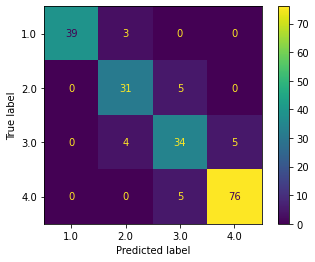

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [ ]:
cm=confusion_matrix(y_test,y_pred)

In [ ]:
labels=[1,2,3,4]
acc_per_class={}
for i in range(len(cm)):
  TP=cm[i,i]
  TN=cm.sum()-cm[i,:].sum()-cm[:,i].sum()
  ACC=(TP+TN)/cm.sum()
  acc_per_class[labels[i]]=ACC

In [ ]:
acc_per_class

{1: 0.6831683168316832,
 2: 0.7524752475247525,
 3: 0.7623762376237624,
 4: 0.6732673267326733}

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
clf2 = SVC(gamma='auto')
clf2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(gamma='auto')

In [ ]:
y_pred2=clf2.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
accuracy_score(y_test,y_pred2)

0.801980198019802

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


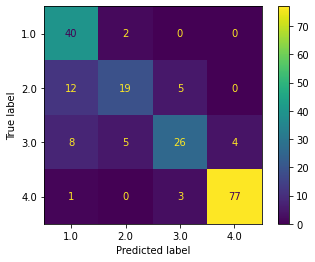

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf2, X_test, y_test)  
plt.show()

In [ ]:
# fit model no training data
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=16,n_estimators=50)
model.fit(X_train, y_train)

# make predictions for test data

y_pred3 = model.predict(X_test)
predictions = [round(value) for value in y_pred3]

# evaluate predictions

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 88.12%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


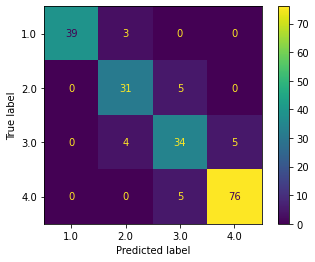

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [ ]:

overlap_per_class={}
for i in range(4):
  TP=cm[i,i]
  TN=cm.sum()-cm[i,:].sum()-cm[:,i].sum()
  ACC=(TP+TN)/cm.sum()
  acc_per_class[labels[i]]=ACC